In [ ]:
from keras.models import Model
from keras.layers import Input,Conv2D, Conv3D, MaxPooling3D,UpSampling2D, UpSampling3D,MaxPooling2D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate,Add
import keras as Ks
from keras.layers import Input
from glob import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2
from skimage import io
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1-2HGO0znF0JAsgZ_et5Cr_owKVxr_bKZ

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=61091bfe04cbd21d3f7ea4026a58d847e3a259d0b643c8c4602557d25f60ba2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zeqti5vy/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-2HGO0znF0JAsgZ_et5Cr_owKVxr_bKZ
To: /content/CT_Data.zip
100% 624M/624M [00:04<00:00, 145MB/s]


In [ ]:
from zipfile import ZipFile

file_name="/content/CT_Data.zip"

with ZipFile(file_name, 'r') as ziip:
  ziip.extractall()
  print('woow')

woow


In [ ]:
mask_files = glob('/content/content/drive/MyDrive/CT_Data/Masks/*')
len(mask_files)

7367

In [ ]:
CT = glob('/content/content/drive/MyDrive/CT_Data/CT_images/*')
len(CT)

7367

In [ ]:
df = pd.DataFrame({"image_path": CT, "mask_path":mask_files})


In [ ]:
Xtrain, Xval = train_test_split(df, test_size=0.15,random_state=101)
Xtest, Xval = train_test_split(Xval, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(Xtrain), len(Xval), len(Xtest)))

Train size is 6261, valid size is 553 & test size is 553


In [ ]:
train_ids = list(Xtrain.image_path)
train_mask = list(Xtrain.mask_path)

val_ids = list(Xval.image_path)
val_mask= list(Xval.mask_path)

In [ ]:
def resblock(X, f):
 
    Xcopy = X  
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    Xcopy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(Xcopy)
    Xcopy = BatchNormalization()(Xcopy)
    
    # Adding the output from main path and short path together
    X = Add()([X, Xcopy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
def tversky(ytrue, ypred):
    ypredpos = K.flatten(ypred)
    ytruepos = K.flatten(ytrue)
    truepos = K.sum(ytruepos * ypredpos)
    falseneg = K.sum(ytruepos * (1-ypredpos))
    falsepos = K.sum((1-ytruepos)*ypredpos)
    alpha = 0.7
    smooth=100
    return (truepos + smooth)/(truepos + alpha*falseneg + (1-alpha)*falsepos + smooth)

def focaltversky(ytrue,ypred):
    ypred = tf.cast(ypred, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    
    pt_1 = tversky(ytrue, ypred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(ytrue, ypred):
    return 1 - tversky(ytrue,ypred)

In [ ]:
def Res_Unet_model(inputshape=(256,256,3),filter_num=8,pool_size=(2, 2),n_classes=3):
  Xinput = Input(inputshape)

  conv_1 = Conv2D(2*filter_num, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(Xinput)
  conv_1 = BatchNormalization()(conv_1)
  conv_1 = Conv2D(2*filter_num, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
  conv_1 = BatchNormalization()(conv_1)
  pool_1 = MaxPool2D(pool_size)(conv_1)


  conv_2 = resblock(pool_1, 4*filter_num)
  pool_2 = MaxPooling2D(pool_size)(conv_2)


  conv_3 = resblock(pool_2, 8*filter_num)
  pool_3 = MaxPooling2D(pool_size)(conv_3)


  conv_4 = resblock(pool_3, 16*filter_num)
  pool_4 = MaxPooling2D(pool_size)(conv_4)


  conv_5 = resblock(pool_4, 32*filter_num)


  up_1 = upsample_concat(conv_5, conv_4)
  up_1 = resblock(up_1, 16*filter_num)


  up_2 = upsample_concat(up_1, conv_3)
  up_2 = resblock(up_2, 8*filter_num)


  up_3 = upsample_concat(up_2, conv_2)
  up_3 = resblock(up_3, 4*filter_num)


  up_4 = upsample_concat(up_3, conv_1)
  up_4 = resblock(up_4, 2*filter_num)


  out = Conv2D(n_classes, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)
  Res_Unet_with_att_model=Model(Xinput, out)
  return Res_Unet_with_att_model

In [ ]:
inputshape = (256,256,3)
Res_Unet_model=Res_Unet_model(inputshape)

In [ ]:
Res_Unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):
    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()
  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]
    X, y = self.__data_generation(list_ids, list_mask)
    return X, y

  def on_epoch_end(self):    
    self.indexes = np.arange(len(self.ids))

    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):

    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 3))

    for i in range(len(list_ids)):
      img_path = str(list_ids[i])
      mask_path = str(list_mask[i])
      img = io.imread(img_path)
      mask = io.imread(mask_path)
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)
      img -= img.mean()
      img /= img.std()
      mask -= mask.mean()
      mask /= mask.std()
      X[i,] = img
      y[i,] = mask
    y = (y > 0).astype(int)
    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/CT_res_unet_32/CT_res_unet_32.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
filename='/content/drive/MyDrive/CT_res_unet_32/history.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, MeanIoU

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.01, epsilon = 0.1)
Res_Unet_model.compile(optimizer = adam, 
                  loss = focaltversky, 
                  metrics = [tversky]
                 )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
Res_Unet_model.load_weights("/content/drive/MyDrive/CT_res_unet/CT_res_unet.h5")

In [ ]:
def prediction(test, model_seg):
    
    mask, image_id, mask_path =  [], [],[]
    
    for i in test.image_path:
        img = io.imread(i)        
        img = img *1./255.
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1,256,256,3))

        X = np.empty((1,256,256,3))
        
        img = io.imread(i)
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        img -= img.mean()
        img /= img.std()
        X[0,] = img
        
        predict = model_seg.predict(X)
        
        image_id.append(i)
        mask.append(predict)
    for i in test.mask_path:
        mask_path.append(i)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'mask_path':mask_path})

In [ ]:
data=prediction(Xtest,Res_Unet_model)

In [ ]:
test_ids = list(Xtest.image_path)
test_mask = list(Xtest.mask_path)
test_data = DataGenerator(test_ids, test_mask)

In [ ]:
tv,dice = Res_Unet_model.evaluate(test_data)
print("UNet Segmentation tversky is {:.2f}%".format(tv*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


34/34 [==============================] - 75s 2s/step - loss: 0.0989 - tversky: 0.9503
UNet Segmentation tversky is 9.89%


In [ ]:
print("UNet Segmentation dice coef. is {:.2f}%".format(dice*100))

UNet Segmentation dice coef. is 95.03%


In [ ]:
data.head()

,image_path,predicted_mask,mask_path
0,/content/content/drive/MyDrive/CT_Data/CT_imag...,[[[[4.1498642e-17 9.3804198e-15 1.7915005e-15]...,/content/content/drive/MyDrive/CT_Data/Masks/5...
1,/content/content/drive/MyDrive/CT_Data/CT_imag...,[[[[1.7596985e-17 6.6520945e-15 1.8552209e-15]...,/content/content/drive/MyDrive/CT_Data/Masks/7...
2,/content/content/drive/MyDrive/CT_Data/CT_imag...,[[[[2.4015555e-17 8.5759358e-15 2.2810383e-15]...,/content/content/drive/MyDrive/CT_Data/Masks/4...
3,/content/content/drive/MyDrive/CT_Data/CT_imag...,[[[[3.2399288e-17 8.0126403e-15 2.1083927e-15]...,/content/content/drive/MyDrive/CT_Data/Masks/1...
4,/content/content/drive/MyDrive/CT_Data/CT_imag...,[[[[4.2721159e-17 9.6798112e-15 2.2032722e-15]...,/content/content/drive/MyDrive/CT_Data/Masks/4...


In [ ]:
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


error: ignored

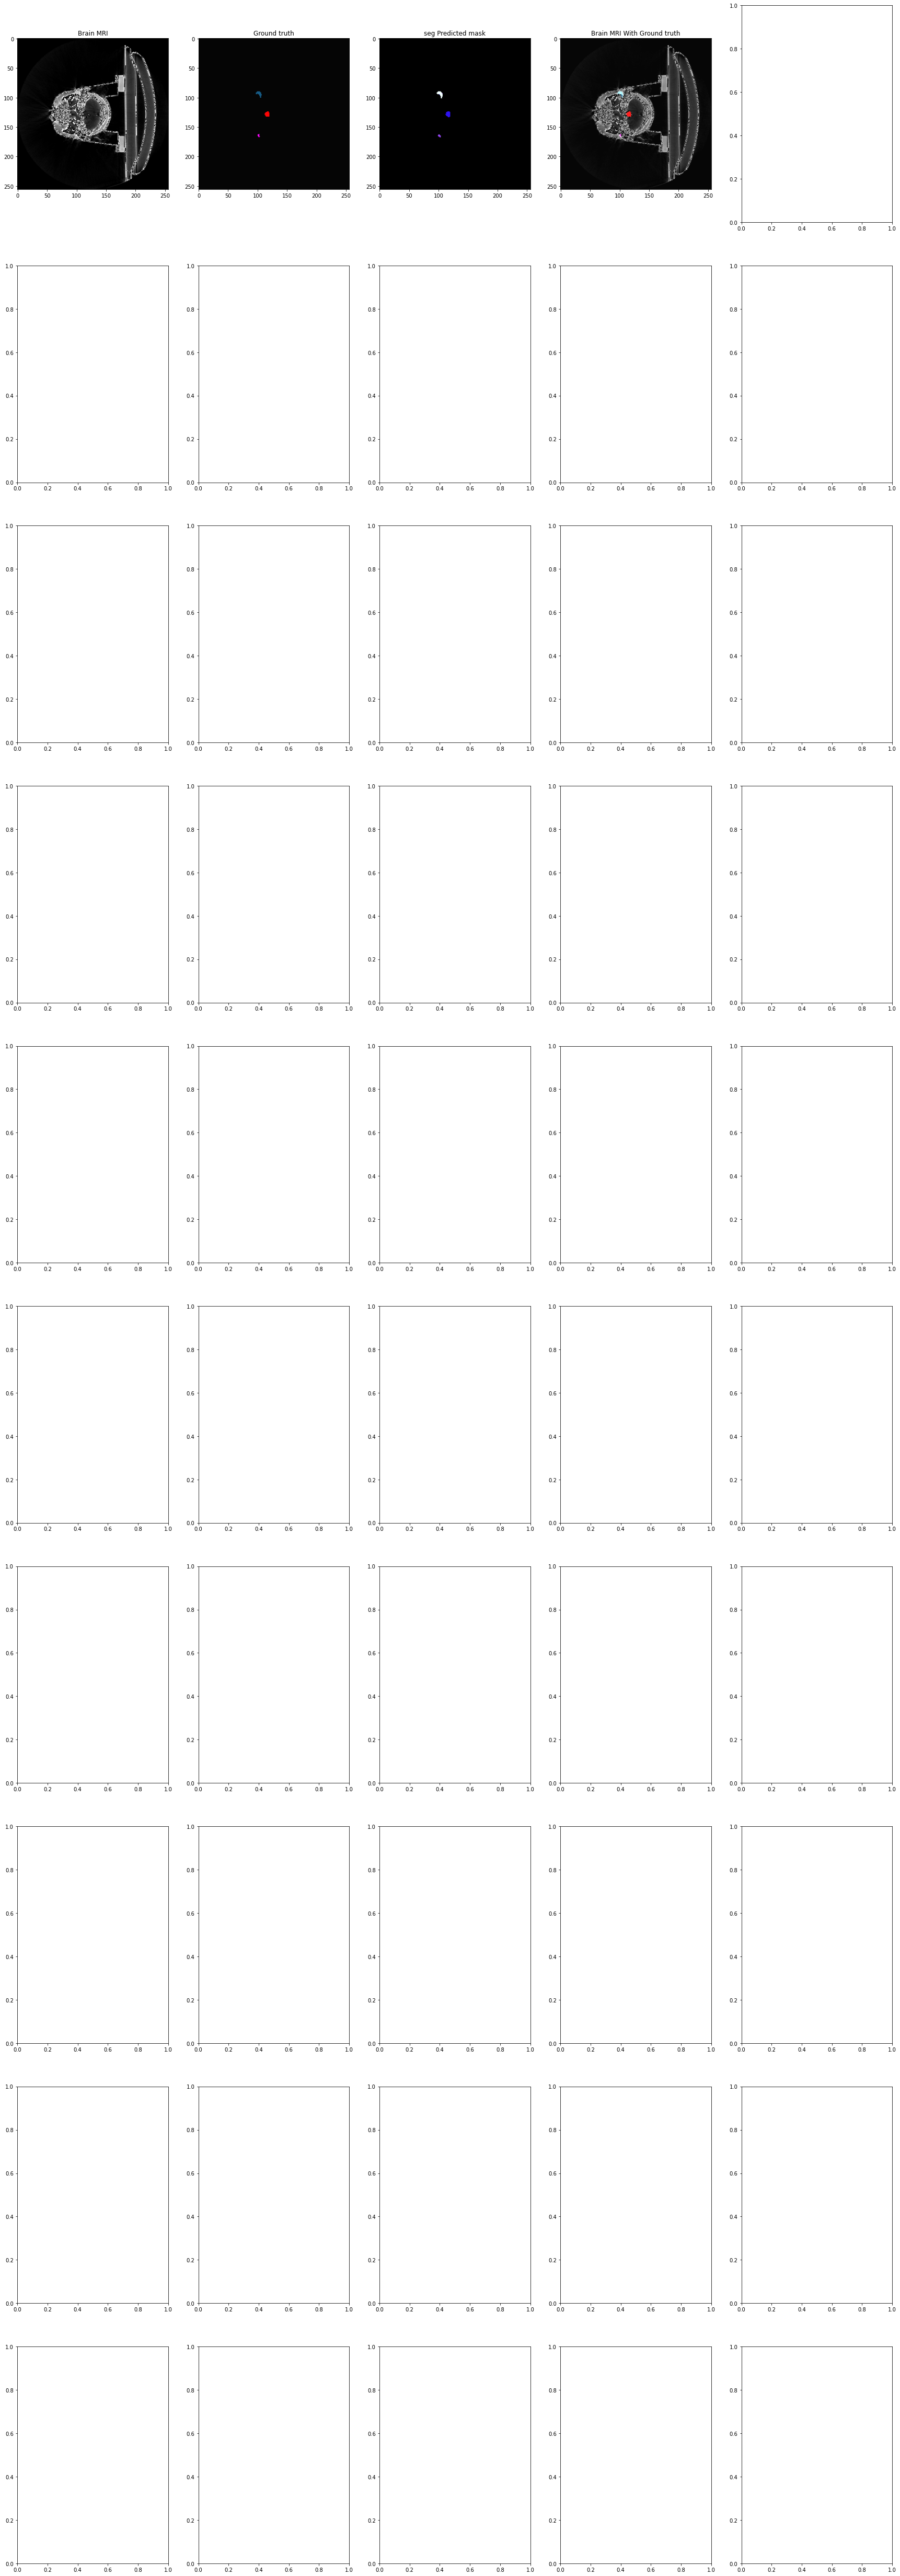

In [ ]:
count = 0
fig, axs = plt.subplots(10,5, figsize=(30,90))
dd=[357,350,123,125,135,139,141,206,241,313,414]
for i in dd:
    if  count<10:
        img = io.imread(data.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        mask = io.imread(data.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground truth')
        
        pred = np.array(data.predicted_mask[i]).squeeze().round()
        pred=cv2.cvtColor(pred, cv2.COLOR_RGB2BGR  )
        pred=cv2.cvtColor(pred, cv2.COLOR_RGB2XYZ )
        # pred=cv2.cvtColor(pred, cv2.COLOR_BGR2HSV  )

        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('seg Predicted mask')
        # img=img.astype(np.uint8)
        img_G=cv2.addWeighted(img,0.8,mask,1,1)

        axs[count][3].imshow(img_G)
        axs[count][3].title.set_text('Brain MRI With Ground truth')

        img_p=cv2.addWeighted(img,0.8,pred,1,1)
        axs[count][4].imshow(img_p)
        axs[count][4].title.set_text('Brain MRI With Predicted mask')
        
        count +=1
    if (count==10):
        break
# plt.savefig('sg.png')
fig.tight_layout()    

[357]

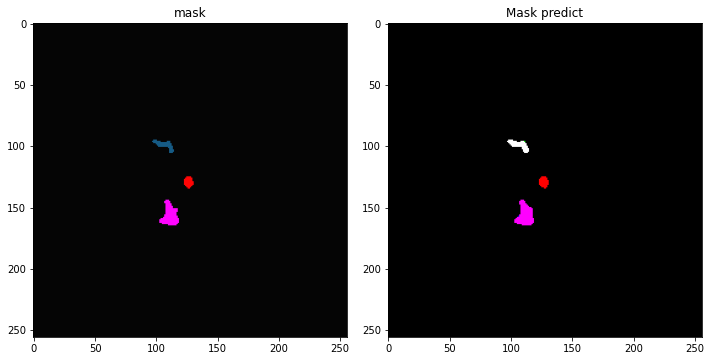

In [ ]:

figure,xs = plt.subplots(1,2, figsize=(10,5))


img = io.imread(data.mask_path[139])
xs[0].title.set_text("mask")
xs[0].imshow(img)

# mask = io.imread(df.mask_path[i])
xs[1].title.set_text("Mask predict")
xs[1].imshow( np.array(data.predicted_mask[139]).squeeze().round())

# img[mask==255] = (0,255,150)  # change pixel color at the position of mask
# xs[count][2].title.set_text("MRI with Mask")
# xs[count][2].imshow(img)

        
figure.tight_layout()

In [ ]:
img=cv2.imread(data.mask_path[350+7])

In [ ]:
mask1=np.zeros([256,256,3],dtype=np.uint8)
mask2=np.zeros([256,256,3],dtype=np.uint8)
mask3=np.zeros([256,256,3],dtype=np.uint8)
mask4=np.zeros([256,256,3],dtype=np.uint8)
mask5=np.zeros([256,256,3],dtype=np.uint8)
mask6=np.zeros([256,256,3],dtype=np.uint8)
for i in range(len(img)):
  for j in range( len(img)):
    if img[i][j][0]<=10 and img[i][j][1]<=10 and img[i][j][2]==255:
      mask1[i][j]=[0,0,255]
    if img[i][j][0]<=10 and img[i][j][1]==255 and img[i][j][2]<=10:
      mask2[i][j]=[0,255,0]
    if img[i][j][0]==255 and img[i][j][1]<=5 and img[i][j][2]<=255:
      mask3[i][j]=[255,0,0]
    if img[i][j][0]==255 and img[i][j][1]==255 and img[i][j][2]<=5:
      mask4[i][j]=[255,255,0]
    if img[i][j][0]==255 and img[i][j][1]<=5 and img[i][j][2]==255:
      mask5[i][j]=[255,0,255]
    if (img[i][j][0]<=150 and img[i][j][0]>=100 )  or (img[i][j][1]<=95 and img[i][j][1]>=85) or (img[i][j][2]<=25 and img[i][j][2]>=15):
      mask6[i][j]=[128,86,17]

In [ ]:
Res_Unet_model.fit(train_data, 
                  epochs = 120,
                  initial_epoch=41,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr,history_logger]
                 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Epoch 42/120
391/391 [==============================] - ETA: 0s - loss: 0.1410 - tversky: 0.9240 - recall: 0.9489 - precision: 0.8836 - mean_io_u: 0.8645
Epoch 42: val_loss improved from inf to 0.20847, saving model to /content/drive/MyDrive/CT_res_unet_32/CT_res_unet_32.h5
391/391 [==============================] - 172s 397ms/step - loss: 0.1410 - tversky: 0.9240 - recall: 0.9489 - precision: 0.8836 - mean_io_u: 0.8645 - val_loss: 0.2085 - val_tversky: 0.8734 - val_recall: 0.8964 - val_precision: 0.8383 - val_mean_io_u: 0.8300 - lr: 0.0100
Epoch 43/120
391/391 [==============================] - ETA: 0s - loss: 0.1369 - tversky: 0.9273 - recall: 0.9504 - precision: 0.8855 - mean_io_u: 0.8652
Epoch 43: val_loss did not improve from 0.20847
391/391 [==============================] - 156s 398ms/step - loss: 0.1369 - tversky: 0.9273 - recall: 0.9504 - precision: 0.8855 - mean_io_u: 0.8652 - val_loss: 0.2143 - val_tversky: 0.8694 - val_recall: 0.8916 - val_precision: 0.8390 - val_mean_io_u: